In [1]:
from typing import Callable, List, Tuple
import pytorch_lightning as pl
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.nn.functional as F
from torch.distributions.distribution import Distribution
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import numpy as np
from NFconstants import N_nod, Beta, a, K_nod
import sys
sys.path.insert(1, './systems')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from NFconstants import N_nod, Beta, a, K_nod
from transforms import t_get_O
from transforms import get_split_masks
from transforms import get_pair_split_masks
from transforms import config_RG_masks
from Data import normal_dist

def set_random_seed(seed):
    torch.manual_seed(seed)

O=t_get_O(N_nod).to(device)
Ot=(torch.t(O)).to(device)






In [3]:
from flows.theta import ThetaNetwork
"""
class ThetaNetwork(nn.Module):
    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        num_hidden: int,
        hidden_dim: int,
        num_params: int,
        p_drop: float,
    ):
        super().__init__()
        self.input = nn.Linear(in_dim, hidden_dim)
        self.hidden = nn.ModuleList(
            [nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.Dropout(p=p_drop),
                nn.LayerNorm(hidden_dim)
            ) for _ in range(num_hidden)]
        )

        self.num_params = num_params
        self.out_dim = out_dim
        self.dims = nn.Linear(hidden_dim, out_dim * num_params)
        
    def configure_theta(num_hidden,hidden_dim,p_drop,in_dim=N_nod//2,out_dim=N_nod//2):
        theta=ThetaNetwork(
                in_dim = in_dim,
                out_dim = out_dim,
                num_hidden = num_hidden,  #2 to 6
                hidden_dim = hidden_dim , #100-1024
                num_params = 2,
                p_drop=p_drop,
        )
        return theta    

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.leaky_relu(self.input(x),negative_slope=0.01)
        for h in self.hidden:
            x = F.leaky_relu(h(x),negative_slope=0.01)

        batch_params = self.dims(x).reshape(x.size(0), self.out_dim, -1) 
        params = batch_params.chunk(self.num_params, dim=-1) 
        return [p.squeeze(-1) for p in params]
"""        

'\nclass ThetaNetwork(nn.Module):\n    def __init__(\n        self,\n        in_dim: int,\n        out_dim: int,\n        num_hidden: int,\n        hidden_dim: int,\n        num_params: int,\n        p_drop: float,\n    ):\n        super().__init__()\n        self.input = nn.Linear(in_dim, hidden_dim)\n        self.hidden = nn.ModuleList(\n            [nn.Sequential(\n                nn.Linear(hidden_dim, hidden_dim),\n                nn.Dropout(p=p_drop),\n                nn.LayerNorm(hidden_dim)\n            ) for _ in range(num_hidden)]\n        )\n\n        self.num_params = num_params\n        self.out_dim = out_dim\n        self.dims = nn.Linear(hidden_dim, out_dim * num_params)\n        \n    def configure_theta(num_hidden,hidden_dim,p_drop,in_dim=N_nod//2,out_dim=N_nod//2):\n        theta=ThetaNetwork(\n                in_dim = in_dim,\n                out_dim = out_dim,\n                num_hidden = num_hidden,  #2 to 6\n                hidden_dim = hidden_dim , #100-1024\n   

In [4]:
from flows.Layers import AffineCouplingLayer
"""
class AffineCouplingLayer(nn.Module):
    def __init__(
        self,
        theta: nn.Module,
        split,
        swap: int
    ):
        super().__init__()
        self.theta = theta
        self.split = split
        self.swap = swap

    def g(self, z: torch.Tensor,params=torch.tensor([])) -> torch.Tensor:
        """
#g : z -> x. The inverse of f.
"""
        mask1=self.split[self.swap]
        mask2=self.split[(self.swap+1)%2]
        z1, z2 = z[:,mask1], z[:,mask2]
        z1 = torch.cat((z1,params),dim=-1)
        t, s = self.theta(z1)
        x2 = z2 * torch.exp(s) + t
        log_det = s.sum(-1) 
        z[:,mask2]=x2
        return z, log_det

    def f(self, x: torch.Tensor,params=torch.tensor([])) -> torch.Tensor:
        mask1=self.split[self.swap]
        mask2=self.split[(self.swap+1)%2]
        x1, x2 = x[:,mask1], x[:,mask2]
        x1 = torch.cat((x1,params),dim=-1)
        t, s = self.theta(x1)
        z1, z2 = x1, torch.exp(-s)*(x2-t) 
        log_det = s.sum(-1) 
        x[:,mask2] = z2
        return x, log_det    
"""        

'\n        mask1=self.split[self.swap]\n        mask2=self.split[(self.swap+1)%2]\n        z1, z2 = z[:,mask1], z[:,mask2]\n        z1 = torch.cat((z1,params),dim=-1)\n        t, s = self.theta(z1)\n        x2 = z2 * torch.exp(s) + t\n        log_det = s.sum(-1) \n        z[:,mask2]=x2\n        return z, log_det\n\n    def f(self, x: torch.Tensor,params=torch.tensor([])) -> torch.Tensor:\n        mask1=self.split[self.swap]\n        mask2=self.split[(self.swap+1)%2]\n        x1, x2 = x[:,mask1], x[:,mask2]\n        x1 = torch.cat((x1,params),dim=-1)\n        t, s = self.theta(x1)\n        z1, z2 = x1, torch.exp(-s)*(x2-t) \n        log_det = s.sum(-1) \n        x[:,mask2] = z2\n        return x, log_det    \n'

In [5]:
from flows.NormalizingFlow import NormalizingFlow
"""
class NormalizingFlow(nn.Module):
    
    def __init__(self, latent: Distribution, flows: List[nn.Module], ort=False, Ot=[]):
        super().__init__()
        self.latent = latent
        self.flows = flows
        self.ort = ort
        self.Ot = Ot
        
    def configure_flows(n_flows,num_hidden,hidden_dim,p_drop,dim=N_nod,param_dim=0):  # n_flows=8,...,12
        flows = []
        split_masks_d = get_pair_split_masks(dim)
        #split_masks_d = get_split_masks(dim)
    
        for k in range(n_flows):
            theta = ThetaNetwork.configure_theta( num_hidden = num_hidden, hidden_dim = hidden_dim, p_drop=p_drop ,in_dim = dim//2+param_dim,out_dim = dim//2)
            flows.append(AffineCouplingLayer(theta,split=split_masks_d,swap=k%2))
   
        flows = nn.ModuleList(flows)
        return flows     

    def latent_sample(self, num_samples: int = 1) -> torch.Tensor:
        z=self.latent.sample((num_samples,))
        return z        

    def sample(self, num_samples: int = 1) -> torch.Tensor:
        Sample a new observation x by sampling z from
        the latent distribution and pass through g.
        z=(self.latent_sample(num_samples))
        with torch.no_grad():
            x, _ = self.g(z)
        return x 
    

    def g(self, z: torch.Tensor,params=torch.tensor([])) -> torch.Tensor:
        
        x, sum_log_abs_det = z, torch.zeros(z.size(0)).to(z.device)
        for flow in reversed(self.flows):
            x, log_abs_det = flow.g(x,params)
            sum_log_abs_det += log_abs_det
        
        if self.ort:
            x = torch.matmul(x,self.Ot.to(x.device))
            
        return x, sum_log_abs_det
    
        
    def __len__(self) -> int:
        return len(self.flows)
    
    def f(self, x: torch.Tensor,params=torch.tensor([])) -> Tuple[torch.Tensor, torch.Tensor]:
        
        with torch.no_grad():
            if self.ort:
                x=torch.matmul(x,O.to(x.device))
        
            z, sum_log_abs_det = x, torch.zeros(x.size(0)).to(x.device)
        
            for flow in self.flows:
                z, log_abs_det = flow.f(z,params)
                sum_log_abs_det += log_abs_det
        
        return z, sum_log_abs_det
"""    
 

    

'\nclass NormalizingFlow(nn.Module):\n    \n    def __init__(self, latent: Distribution, flows: List[nn.Module], ort=False, Ot=[]):\n        super().__init__()\n        self.latent = latent\n        self.flows = flows\n        self.ort = ort\n        self.Ot = Ot\n        \n    def configure_flows(n_flows,num_hidden,hidden_dim,p_drop,dim=N_nod,param_dim=0):  # n_flows=8,...,12\n        flows = []\n        split_masks_d = get_pair_split_masks(dim)\n        #split_masks_d = get_split_masks(dim)\n    \n        for k in range(n_flows):\n            theta = ThetaNetwork.configure_theta( num_hidden = num_hidden, hidden_dim = hidden_dim, p_drop=p_drop ,in_dim = dim//2+param_dim,out_dim = dim//2)\n            flows.append(AffineCouplingLayer(theta,split=split_masks_d,swap=k%2))\n   \n        flows = nn.ModuleList(flows)\n        return flows     \n\n    def latent_sample(self, num_samples: int = 1) -> torch.Tensor:\n        z=self.latent.sample((num_samples,))\n        return z        \n\n    

In [6]:
from flows.RGflows import RGflows
"""
class RGflows(nn.Module):
    
    def __init__(self,latent: Distribution ,
                 nflist, 
                 masks, 
                 n_flows_dict,
                 num_hidden_dict,
                 hidden_dim_dict,
                 gr_ng=0,
                 out_dim=N_nod,
                 p_drop=0):
        super().__init__()
        self.latent = latent
        self.nflist = nflist
        self.masks = masks
        self.n_flows_dict = n_flows_dict
        self.num_hidden_dict = num_hidden_dict
        self.hidden_dim_dict = hidden_dim_dict
        self.out_dim = out_dim
        self.gr_ng = gr_ng
        O=(t_get_O(out_dim)).to(device)
        self.Ot=(torch.t(O)).to(device)
        self.p_drop=p_drop
        
    def set_out_dim(self,out_dim):
        self.out_dim=out_dim
        O=(torch.tensor(get_O(self.out_dim)).float()).to(device)
        self.Ot=(torch.t(O)).to(device)
        
    def configure_RG_flows(masks,n_flows_dict,num_hidden_dict,hidden_dim_dict,p_drop=0):  
        nflist=[]
        dim = len(masks[0])
        param_dim = 0
        for k in range(len(masks)):
            flows =  NormalizingFlow.configure_flows(n_flows = n_flows_dict[dim] , num_hidden = num_hidden_dict[dim] , hidden_dim = hidden_dim_dict[dim], dim = dim , param_dim = param_dim, p_drop = p_drop)
            nflist.append(NormalizingFlow(latent=normal_dist,flows=flows,ort=False))
            param_dim += dim 
            if k!=0: dim *= 2 
        nflist = nn.ModuleList(nflist)        
        return nflist    
        
    def configure_RG_model(latent,masks,n_flows_dict, num_hidden_dict,hidden_dim_dict,out_dim=N_nod,gr_ng=0,p_drop=0):
        flows=RGflows.configure_RG_flows(masks,n_flows_dict,num_hidden_dict,hidden_dim_dict,p_drop=p_drop)
        return RGflows(latent,flows,RGmasks,n_flows_dict,num_hidden_dict,hidden_dim_dict,gr_ng=gr_ng,out_dim=out_dim,p_drop=p_drop)
    
    def save(self,filename):
        state_dict = self.state_dict()
        model_dict={"state_dict":state_dict,
                    "n_flows_dict":self.n_flows_dict,
                    "num_hidden_dict":self.num_hidden_dict,
                    "hidden_dim_dict":self.hidden_dim_dict,
                    "masks":self.masks,
                    "p_drop":self.p_drop}
        torch.save(model_dict,filename)
    
    def load_model(filename):   
        model_dict = torch.load(filename,map_location = device)
        model=RGflows.configure_RG_model(normal_dist,
                                  model_dict["masks"],
                                  model_dict["n_flows_dict"], 
                                  model_dict["num_hidden_dict"],
                                  model_dict["hidden_dim_dict"],
                                  p_drop=model_dict["p_drop"])
        model.load_state_dict(model_dict["state_dict"])
        return model
        

    def latent_sample(self, num_samples: int = 1) -> torch.Tensor:
        z=self.latent.sample((num_samples,))
        return z        

    def sample(self, num_samples: int = 1) -> torch.Tensor:
        Sample a new observation x by sampling z from
        the latent distribution and pass through g.
        z=(self.latent_sample(num_samples))
        with torch.no_grad():
            x, _ = self.g(z)
        return x 
    

    def g(self, z: torch.Tensor,params=torch.tensor([])) -> torch.Tensor:
        
        sum_log_abs_det = torch.zeros(z.size(0)).to(z.device)
        params=torch.tensor([]).to(z.device)
        full_mask = []
        
        with torch.no_grad():
            for i in range(0,self.gr_ng):
                x = z[:,self.masks[i]]
                x, log_abs_det = ((self.nflist)[i]).g(x,params)
                sum_log_abs_det += log_abs_det
                params = torch.cat((params,x.detach()),dim=-1)
                z[:,self.masks[i]] = x
                full_mask += self.masks[i]
        
        for i in range(self.gr_ng,len(self.nflist)):
            x = z[:,self.masks[i]]
            x, log_abs_det = ((self.nflist)[i]).g(x,params)
            sum_log_abs_det += log_abs_det
            params = torch.cat((params,x.detach()),dim=-1)
            z[:,self.masks[i]] = x
            full_mask += self.masks[i]          
            if len(full_mask) == self.out_dim:
                full_mask.sort()
                z = torch.matmul(z[:,full_mask],self.Ot.to(z.device))    
                return z, sum_log_abs_det
        
        z = torch.matmul(z,self.Ot.to(z.device))    
        return z, sum_log_abs_det
    
    def f(self, x: torch.Tensor,params=torch.tensor([])) -> torch.Tensor:
        
        with torch.no_grad():
            sum_log_abs_det = torch.zeros(x.size(0)).to(x.device)
            params=torch.tensor([]).to(x.device)
            x = torch.matmul(x,O.to(x.device))
        
            for i in range(len(self.nflist)):
                z = x[:,self.masks[i]]
                tmp = z.clone()
                z, log_abs_det = ((self.nflist)[i]).f(z,params)
                sum_log_abs_det += log_abs_det
                params = torch.cat((params,tmp.detach()),dim=-1)
                x[:,self.masks[i]] = z    
        return x, sum_log_abs_det
    
    def log_prob(self,x):
        tmp = x.clone()
        z, lad = self.f(tmp)
        log_prob = -torch.sum(z**2/2,dim=-1)-lad
        return log_prob
    
    
    def g_samp(self, z: torch.Tensor,params=torch.tensor([])) -> torch.Tensor:
        
        sum_log_abs_det = torch.zeros(z.size(0)).to(z.device)
        params = torch.tensor([]).to(z.device)
        res = torch.zeros((z.shape[0],z.shape[1]))
        
        for i in range(len(self.nflist)):
            x=z[:,self.masks[i]]
            res1, log_abs_det = ((self.nflist)[i]).g(x,params)
            sum_log_abs_det += log_abs_det
            params = torch.cat((params,x),dim=-1)
            res[:,self.masks[i]] = res1
        res = torch.matmul(res,Ot.to(z.device))    
        return res, sum_log_abs_det
    
        
    def __len__(self) -> int:
        return len(self.flows)
    
    def forward(self,z,grads=False):
        t=z.clone()
        with torch.no_grad():
            x, log_abs_det=self.g(t)


        return x, log_abs_det
"""    
 

    

'\nclass RGflows(nn.Module):\n    \n    def __init__(self,latent: Distribution ,\n                 nflist, \n                 masks, \n                 n_flows_dict,\n                 num_hidden_dict,\n                 hidden_dim_dict,\n                 gr_ng=0,\n                 out_dim=N_nod,\n                 p_drop=0):\n        super().__init__()\n        self.latent = latent\n        self.nflist = nflist\n        self.masks = masks\n        self.n_flows_dict = n_flows_dict\n        self.num_hidden_dict = num_hidden_dict\n        self.hidden_dim_dict = hidden_dim_dict\n        self.out_dim = out_dim\n        self.gr_ng = gr_ng\n        O=(t_get_O(out_dim)).to(device)\n        self.Ot=(torch.t(O)).to(device)\n        self.p_drop=p_drop\n        \n    def set_out_dim(self,out_dim):\n        self.out_dim=out_dim\n        O=(torch.tensor(get_O(self.out_dim)).float()).to(device)\n        self.Ot=(torch.t(O)).to(device)\n        \n    def configure_RG_flows(masks,n_flows_dict,num_hidden_

In [7]:
m=3
RGmasks = config_RG_masks(3,N_nod)

In [8]:
print(RGmasks)

[[0, 1, 16, 17, 32, 33, 48, 49], [8, 9, 24, 25, 40, 41, 56, 57], [4, 5, 12, 13, 20, 21, 28, 29, 36, 37, 44, 45, 52, 53, 60, 61], [2, 3, 6, 7, 10, 11, 14, 15, 18, 19, 22, 23, 26, 27, 30, 31, 34, 35, 38, 39, 42, 43, 46, 47, 50, 51, 54, 55, 58, 59, 62, 63]]


In [9]:
class Pipeline(pl.LightningModule):
    def __init__(
        self,
        model,
        criterion,
        optimizer_class=torch.optim.Adam,
        optimizer_kwargs={"lr": 0.001,"weight_decay": 0}
    ) -> None:
        super().__init__()
        self.model = model
        self.loss = criterion
        self.optimizer_class = optimizer_class
        self.optimizer_kwargs = optimizer_kwargs

    """
    def configure_optimizers(self):
        optimizer = self.optimizer_class(
            self.model.parameters(), **self.optimizer_kwargs
        )
        return optimizer
    """
    
    def configure_optimizers(self):
        optimizer = self.optimizer_class(self.model.parameters(), **self.optimizer_kwargs)
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer,
            min_lr=1e-4,
            factor=0.8,
            mode="min",
            verbose=True,
        )

        lr_scheduler = {
            "scheduler": scheduler,
            "interval": "epoch",
            "monitor": "train_loss",
        }
        return [optimizer], [lr_scheduler]

    def training_step(self, batch, batch_idx):
        z = batch
        x, log_abs_det = self.model.g(z)
        loss = self.loss(x,log_abs_det)
        sch = self.lr_schedulers()
        sch.step(loss)
        self.log('train_loss', loss,prog_bar=True)
        self.log('lr',sch.get_last_lr()[0],prog_bar=True)
        #print(loss)
        return loss


    def on_train_epoch_end(self):
        #print("---------------------------end epoch---------------------------------")
        pass
    
    def on_validation_end(self) -> None:
        if not self.automatic_optimization:
            # Save a checkpoint of the model
            ckpt_path = os.path.join(self.trainer.log_dir, 'checkpoints', 'ckpt.pt')
            self.trainer.save_checkpoint(ckpt_path, weights_only=True)
        return super().on_validation_end()
    
    

In [10]:
class MY_Dataset(Dataset):
    def __init__(self, distribution,n_nod):
        super().__init__()
        self.distribution = distribution
        self.n_nod = n_nod
        self.features = torch.tensor(0)
        self.n_sample = 2**14

    def __len__(self):
        return self.n_sample

    def __getitem__(self, index):
        return self.distribution.sample((1,))[0]
    
    def sample(self,n_sample):
        self.features=self.distribution.sample((n_sample,))
        
normal_dist=torch.distributions.Normal(loc=torch.zeros(N_nod), scale=torch.ones(N_nod))
DS=MY_Dataset(normal_dist,N_nod)
train_loader = DataLoader(DS, batch_size=2**10, shuffle=True)

normal_dist8=torch.distributions.Normal(loc=torch.zeros(8), scale=torch.ones(8))
DS8=MY_Dataset(normal_dist8,8)
train_loader8 = DataLoader(DS8, batch_size=2**14, shuffle=True)

In [11]:
from systems.Nonrel.oscillator import Oscillator
from systems.Nonrel.x4 import X4
from systems.Nonrel.Morse import Morse
from systems.Nonrel.twowells import Two_wells
from systems.Nonrel.Columb import Columb

from systems.Rel.rel_oscillator import Rel_Oscillator
from systems.Rel.rel_Morse import Rel_Morse
from systems.Rel.rel_twowells import Rel_two_wells
from systems.Rel.rel_Columb import Rel_Columb

from systems.Ultrarel.ur_oscillator import Ur_Oscillator

In [12]:
osc = Oscillator(N_nod,16)
anh = X4(N_nod,16,g=1)
morse = Morse(N_nod,16,alpha=0.5)
tw = Two_wells(N_nod,16,g=1,x0=1.41)
columb = Columb(N_nod,16,alpha=1,R=1)

rel_osc = Rel_Oscillator(N_nod,16,sigma=1)
rel_morse = Rel_Morse(N_nod,16,m=1,alpha=0.5)
rel_tw = Rel_two_wells(N_nod,16,m=1,g=1,x0=1.41)
rel_columb = Rel_Columb(N_nod,16,m=1,alpha=1,R=1)

ur = Ur_Oscillator(N_nod,16)

In [13]:
hidden_dim_dict1={8:8,16:16,32:32,64:64,128:128}
n_flows_dict1={8:6,16:8,32:10,64:10,128:10}
num_hidden_dict1={8:8,16:12,32:14,64:14,128:14}

In [14]:
set_random_seed(42)
rg = RGflows.configure_RG_model(normal_dist,RGmasks,n_flows_dict1,num_hidden_dict1,hidden_dim_dict1,p_drop=0.0)
rg.save("model_weights_osc.pth")
#print(rg)

In [237]:
sch = pipeline.lr_schedulers()
print(sch.get_last_lr())

[0.001]


In [29]:
set_random_seed(42)
rg = RGflows.load_model("model_weights_osc.pth")
#d = 3
#dim = 2**(m+d)
#rg.gr_ng = d
#rg.set_out_dim(dim)
pipeline=Pipeline(model=rg,criterion = osc.get_KL(), optimizer_class=torch.optim.Adam,optimizer_kwargs={"lr": 0.001})

trainer = pl.Trainer(
    max_epochs=200,
    logger = TensorBoardLogger(save_dir=f"./logs/nf"),
    num_sanity_val_steps=0,
    log_every_n_steps=1,
    enable_checkpointing=False,
    accumulate_grad_batches=4
)

trainer.fit(model=pipeline, train_dataloaders=train_loader)
rg.save("model_weights_osc.pth")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\SEVA1\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | RGflows   | 227 K  | train
1 | loss  | KL_with_S | 0      | train
--------------------------------------------
227 K     Trainable params
0         Non-trainable params
227 K     Total params
0.911     Total estimated model params size (MB)
C:\Users\SEVA1\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve 

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=200` reached.


In [31]:
from Data import normal_dist
import numpy as np
from NFconstants import N_traj
#d = 5
#dim = 2**(m+d)
RG_trained = RGflows.load_model("model_weights_osc.pth")
RG_trained.eval()
#RG_trained.set_out_dim(dim)
N_traj=1000
trajs = RG_trained.sample(N_traj)

In [32]:
from tqdm import tqdm
#T=torch.tensor(get_T(N_nod)).float()
def G(X,n_p="all"):
    n_traj=X.shape[0]
    n_nod=X.shape[1]
    if n_p == "all":
        n_p = X.shape[1]
    G=np.zeros((n_p))
    Y=X.clone()
    Xt=torch.t(X)
    for s in tqdm(range(n_p)):
        G[s]=torch.trace(torch.matmul(Y,Xt))
        Y=torch.roll(Y,-1,1)
        #Y=torch.roll(Y,-1,1)
    return G/(n_traj*n_nod)
g_nf=G(trajs)


100%|█████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 408.74it/s]


In [35]:
from systems.Nonrel.osc_andist import calc_G
from NFconstants import N_nod, N_traj, NG_points,Beta
g_osc=calc_G(N_nod,Beta,N_nod)


In [36]:
g_ur = np.genfromtxt("g_ur N=256 Beta=16")

0.49349859619140624


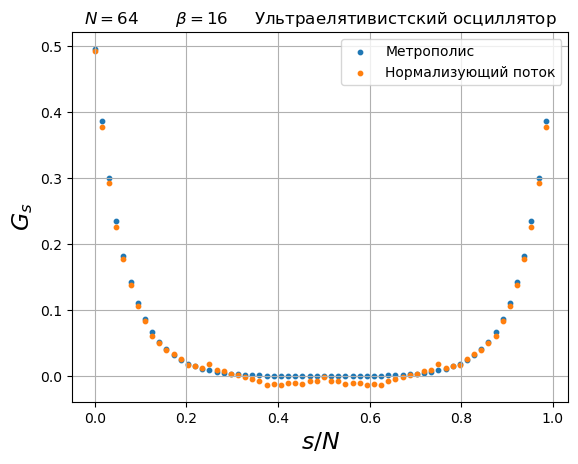

In [37]:
#import sys
#sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
from NFconstants import N_nod, N_traj, NG_points,Beta




g=g_osc
print(g_nf[0])
fig=plt.figure()
MCMC_list=np.arange(len(g))/len(g)
NF_list=np.arange(len(g_nf))/len(g_nf)



plt.scatter(MCMC_list,g,s=10)
plt.scatter(NF_list,g_nf,s=10)
plt.legend(["Метрополис","Нормализующий поток"])
plt.title(r"$N=$"+str(N_nod)+"       "r"$\beta=$"+str(Beta)+"     Ультраелятивистский осциллятор")
plt.ylabel(r"$G_s$",fontsize=17)
plt.xlabel(r"$s/N$",fontsize=17)
#plt.yscale("log")
plt.grid(True)
plt.show()


In [73]:
from NFandist import calc_G
from NFconstants import N_nod, N_traj, NG_points,Beta
g_nf=G(z)


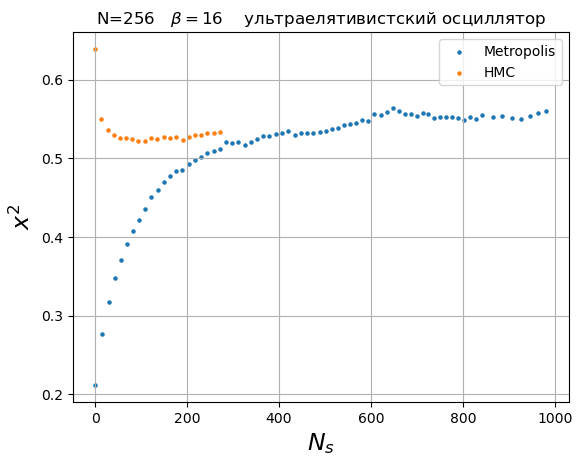

In [76]:

import numpy as np
import matplotlib.pyplot as plt
from NFconstants import N_nod, N_traj, NG_points,Beta



fig=plt.figure()
#plt.scatter(Metropolis_b.Times,Metropolis_b.res,s=5)
plt.scatter(Lang_NN_old.Times,Lang_NN_old.res,s=5)
plt.scatter(Lang.Times,Lang.res,s=5)
plt.xlabel(r"$N_s$",fontsize=17)
plt.ylabel(r"$x^2$",fontsize=17)
plt.legend(["Metropolis","HMC","HMC latent","Normalizing flow+HMC"])
plt.title("N="+str(N_nod)+"   "+r"$\beta=$"+str(Beta)+"    ультраелятивистский осциллятор")
plt.grid(True)
plt.show()